In [1]:
import hashlib
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Input metadata.
exp_dirs_code_hashes = [# [ '../experiment_data/pilot_june9/', 'thowpbr_pilot0'],  # format too old
                        # ['../experiment_data/pilot_june12a/', 'thowpbr_pilot0'],  # format too old
                        ['../experiment_data/pilot_june12b/', 'thowpbr_pilot0'],
                        ['../experiment_data/june16a/', 'thowpbr_main0'],
                        ['../experiment_data/june16b/', 'thowpbr_main0'],
                        ['../experiment_data/june16c/', 'thowpbr_main0'],
                        ['../experiment_data/june19/', 'thowpbr_main1'],
                        ['../experiment_data/june20/', 'thowpbr_main1']
                       ]

csv_names = ['mturk.csv', 'qual.csv', 'main.csv']
log_dir = 'www/log/'
feedback_dir = 'www/feedback'

# Set by MP
METERS_FOR_SUCCESS = 3  # how many meters from the target pano count as success

# Set by HIT.
ORACLE_FUTURE_LEN = 5

# Load house targets.
tasks_fn = 'resources/house_target_tuple.json'
with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)
all_targets = set()
for scan in house_target_tuple:
    all_targets = all_targets.union(set([task_tuple[0] for task_tuple in house_target_tuple[scan]]))
    
# Get distances and hops across scans.
import networkx as nx
from generate_start_end_pairs import load_nav_graphs
house_hops = {}
house_dists = {}
for house in set(house_target_tuple.keys()):
    graph = load_nav_graphs([house])[house]
    hops = dict(nx.all_pairs_dijkstra_path(graph))
    house_hops[house] = hops
    dists = dict(nx.all_pairs_dijkstra_path_length(graph))
    house_dists[house] = dists
    
def get_shortest_planner_path(house, start_pano, end_panos):
    full_trajs = [house_hops[house][start_pano][end_pano] for end_pano in end_panos]
    full_traj_lens = [len(full_trajs[idx]) for idx in range(len(full_trajs))]
    return full_trajs[full_traj_lens.index(min(full_traj_lens))]

def calculate_success(scan, path, gold, within_meters=0, within_hops=0):
    return 1. if (house_dists[scan][path[-1]][gold[-1]] <= within_meters or
                 len(house_hops[scan][path[-1]][gold[-1]]) <= within_hops) else 0.

def calculate_oracle_success(scan, path, gold, within_meters=0, within_hops=0):
    return 1. if np.any([house_dists[scan][path_pano][gold[-1]] <= within_meters or
                        len(house_hops[scan][path_pano][gold[-1]]) <= within_hops
                        for path_pano in path]) else 0.

def get_oracle_first_nearest(scan, path, gold, within_meters=0, within_hops=0):
    for path_pano in path:
        if (house_dists[scan][path_pano][gold[-1]] <= within_meters or
            len(house_hops[scan][path_pano][gold[-1]]) <= within_hops):
             return path_pano
    return None

def calculate_spl(scan, path, gold, within_meters=0, within_hops=0):
    return 1. / len(path) if calculate_success(scan, path, gold,
                                               within_meters=within_meters, within_hops=within_hops) else 0.

def calculate_oracle_spl(scan, path, gold, within_meters=0, within_hops=0):
    nearest = get_oracle_first_nearest(scan, path, gold, within_meters=within_meters, within_hops=within_hops)
    if nearest is not None:
        return 1. / len(path[:path.index(nearest)]) if path.index(nearest) > 0 else 1.
    return 0.

def flip_dict(d):
    g = {}
    for key in d:
        if type(d[key]) is list:
            for e in d[key]:
                g[e] = key
        else:
            if d[key] not in g:
                g[d[key]] = []
            g[d[key]].append(key)
    return g
    
# Output metadata.
games_fn = '../tasks/dialog_navigation/all.json'
instruction_following_dir = '../tasks/instruction_following/'
question_asking_dir = '../tasks/question_asking/'
question_answering_dir = '../tasks/question_answering/'
dialog_navigation_dir = '../tasks/dialog_navigation/'

In [15]:
# Read in the CSV from Turk and connect each player to their respective logfile to rebuild games.

include_problem_games = False

workers_read = workers_bad_code = workers_wrong_hash = num_unpaired = workers_lost = 0
games_logs_read = invalid_game_logs = 0
skipped_for_invalid_pano = skipped_for_invalid_target = skipped_for_invalid_hop = 0
games_timed_out = 0
worker_times_raw = []
games = pd.DataFrame(columns=["idx",  # own idx in dataframe
                              "problem",  # sum of problem reporting by users (e.g., 0, 1, or 2)
                              "navigator",  # uid of the navigator
                              "oracle",  # uid of the oracle
                              "navigator_quality",  # rated quality of the navigator from the oracle
                              "oracle_quality",  # rated quality of the oracle from the navigator
                              "navigator_mturk",  # wid of navigator
                              "oracle_mturk",  # wid of oracle
                              "scan",  # the house the game took place in
                              "target",  # the target object described by the hint
                              "start_pano",  # the starting panorama
                              "end_panos",  # list of valid ending panoramas
                              "R2R_spl",  # shortest_path/path_len if success, 0 otherwise
                              "R2R_oracle_spl",  # shortest_path/path_len_trimmed
                              "nav_steps",  # the panorama jumps taken during navigation (no camera movements)
                              "nav_camera",  # the camera movements preceeding nav steps where questions were asked
                              "dialog_history",  # the full dialog history (both navigator and oracle)
                              "stop_history",  # list of 'nav_step' idxs where navigator attempted a stop action
                              "planner_nav_steps",  # the path the planner would have taken from start to end
                              ])
skipped_game_uids = set()
feedbacks = []
workers_to_uids = {}  # str->str
uids_to_workers = {}
uids_timeout = []
for exp_dir, surveycode_hash in exp_dirs_code_hashes:
    print("Reading from '%s'" % exp_dir)
    for csv_name in csv_names:
        csv_fn = os.path.join(exp_dir, csv_name)
        if not os.path.isfile(csv_fn):
            continue
        print("Reading from csv name '%s'" % csv_name)
        mturk = pd.read_csv(csv_fn)
        for idx in mturk.index:
            workers_read += 1 
            worker_times_raw.append(mturk['WorkTimeInSeconds'][idx])
            # Approve surveycode.
            surveycode = mturk['Answer.surveycode'][idx]
            wid = mturk['WorkerId'][idx]
            if wid not in workers_to_uids:
                workers_to_uids[wid] = []
            if '_' not in surveycode or surveycode.count('_') != 1:
                print('WARNING: worker %s has invalid surveycode "%s"' % (wid, surveycode))
                workers_bad_code += 1
                continue
            uid, hashcode = mturk['Answer.surveycode'][idx].split('_')
            workers_to_uids[wid].append(uid)
            uids_to_workers[uid] = wid
            if uid in skipped_game_uids:
                continue
            hash_str = 'phm_salted_hash%s%s' % (uid, surveycode_hash)
            correcthash = hashlib.sha1(hash_str.encode('utf-8')).hexdigest()[:13]
            if correcthash != hashcode:
                print('WARNING: worker %s has wrong hash %s does not match target %s' % (wid, hashcode, correcthash))
                workers_wrong_hash += 1
                continue

            # Find the feedback file for this user.
            uid_feedback_fn = None
            for _, _, fns in os.walk(os.path.join(exp_dir, feedback_dir)):
                for fn in fns:
                    if fn.split('.')[-1] == 'json' and fn.split('_')[0] == uid:
                        uid_feedback_fn = os.path.join(exp_dir, feedback_dir, fn)
            if uid_feedback_fn is None:
                workers_lost += 1
                continue
            with open(uid_feedback_fn) as f:
                feedback = json.load(f)
            role = 'navigator' if feedback['navigator'] == uid else 'oracle'
            pid_role = 'navigator' if role == 'oracle' else 'oracle'
            pid = feedback['navigator'] if role == 'oracle' else feedback['oracle']
            pid_rating = int(feedback['rating']) if feedback['rating'] is not None else None
            str_feedback = feedback['free_form_feedback']
            feedbacks.append((wid, str_feedback))
            problem = 0
            if 'problem' in feedback:
                problem = 1 if feedback['problem'] is not None else 0
            problem = int(problem)

            # Already have game information for this user, so we just need to update the game with their
            # rating of their partner.
            if len(pid) > 0:
                if pid in games.loc[games['navigator'] == pid]['navigator'].values:
                    games.at[games['navigator'] == pid, 'navigator_quality'] =\
                        int(pid_rating) if pid_rating is not None else -1
                    games.at[games['navigator'] == pid, 'oracle_mturk'] = wid
                    games.at[games['navigator'] == pid, 'problem'] =\
                        games.loc[games['navigator'] == pid, 'problem'].values[0] + problem
                    continue
                elif pid in games.loc[games['oracle'] == pid]['oracle'].values:
                    games.at[games['oracle'] == pid, 'oracle_quality'] =\
                        int(pid_rating) if pid_rating is not None else -1
                    games.at[games['oracle'] == pid, 'navigator_mturk'] = wid
                    games.at[games['oracle'] == pid, 'problem'] =\
                        games.loc[games['oracle'] == pid, 'problem'].values[0] + problem
                    continue

            # Find the logfile and partner id for this user.
            game_log_found = False
            for _, _, fns in os.walk(os.path.join(exp_dir, log_dir)):
                for fn in fns:
                    if ('.' in fn and fn.split('.')[-1] == 'log' and
                        '_' in fn and uid in fn.split('.')[0].split('_')):
                        games_logs_read += 1
                        game_log_found = True
                        uids_in_fn = fn.split('.')[0].split('_')
                        pid = uids_in_fn[0] if uid == uids_in_fn[1] else uids_in_fn[1]

                        # Need to create game information for this unseen pair.
                        navigator = oracle = None
                        navigator_wid = oracle_wid = None
                        navigator_quality = oracle_quality = -1
                        house = target = start_pano = end_panos = None
                        success = False
                        timed_out = False
                        nav_steps = []
                        nav_camera = []
                        dialog_history = []
                        stop_history = []
                        curr_pano = None
                        curr_camera_moves = []
                        curr_turn = "navigator"
                        game_log_fn = os.path.join(exp_dir, log_dir, fn)
                        with open(game_log_fn, 'r') as f:
                            logfile_lines = f.readlines()
                        target_valid = True
                        hops_valid = True
                        for line in logfile_lines:
                            line_parts = line.strip().split('\t')
                            time, sender, receiver, data_str = line_parts
                            data_str = re.sub(r'(?!(([^"]*"){2})*[^"]*$)\'', "\\'", data_str)
                            data_str = data_str.replace("'", '"')
                            line_data = json.loads(data_str)

                            if line_data['action'] == 'set_house':
                                house = line_data['value']
                            elif line_data['action'] == 'set_target_obj':
                                target = line_data['value']
                                if target not in all_targets:
                                    target_valid = False
                                    break
                            elif line_data['action'] == 'set_start_pano' and start_pano is None:
                                start_pano = line_data['value']
                                curr_pano = start_pano
                                nav_steps.append(curr_pano)
                            elif line_data['action'] == 'set_end_panos':
                                end_panos = line_data['value'].split(',')
                            elif (line_data['action'] == 'set_aux' and 
                                  "You are The Navigator" in line_data["message"] and receiver == uid):
                                navigator = uid
                                navigator_wid = wid
                                oracle = pid
                                oracle_quality = int(pid_rating) if pid_rating is not None else -1
                            elif (line_data['action'] == 'set_aux' and
                                  "You are The Oracle" in line_data["message"] and receiver == uid):
                                oracle = uid
                                oracle_wid = wid
                                navigator = pid
                                navigator_quality = int(pid_rating) if pid_rating is not None else -1
                            elif line_data['action'] == 'nav':
                                if line_data['message']['img_id'] != curr_pano:
                                    # Sanity check that this move was possible (interface bugs seem to let
                                    # players occassionally teleport).
                                    next_pano = line_data['message']['img_id']
                                    planner_hops = len(house_hops[house][curr_pano][next_pano])\
                                        if next_pano in house_hops[house][curr_pano] else -1
                                    if planner_hops > 3:  # Sometimes player can skip over a cylinder planner wants to use.
                                        print("WARNING: skipping game from scan %s due to bad hop %s->%s (%d)" %
                                             (house, curr_pano, next_pano, planner_hops))
                                        skipped_for_invalid_hop += 1
                                        hops_valid = False
                                        break
                                    if planner_hops == -1:
                                        print("WARNING: skipping game from scan %s due to impossible hop %s->%s" %
                                             (house, curr_pano, next_pano))
                                        skipped_for_invalid_hop += 1
                                        hops_valid = False
                                        break
                                    curr_pano = next_pano
                                    nav_steps.append(curr_pano)
                                    curr_camera_moves = []
                                curr_camera_moves.append({'pano': line_data['message']['img_id'],
                                                          'heading': (line_data['message']['rot']['_x'] + 1) 
                                                          * np.pi,
                                                          'elevation': (line_data['message']['rot']['_y'] + 35)
                                                          * 0.5,
                                                         })
                            elif line_data['action'] == 'chat':
                                if curr_turn == 'navigator':  # add camera steps preceeding question
                                    nav_camera.append({"nav_idx": len(nav_steps) - 1,
                                                       "dia_idx": len(dialog_history),
                                                       "message": curr_camera_moves})
                                if curr_turn == role:
                                    dialog_history.append({"uid": uid,
                                                           "role": role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                else:
                                    dialog_history.append({"uid": pid,
                                                           "role": pid_role,
                                                           "nav_idx": len(nav_steps) - 1,
                                                           "message": line_data['message'].replace('"', "'")})
                                curr_turn = "navigator" if curr_turn == "oracle" else "oracle"
                            elif line_data['action'] == 'guess_stop':
                                stop_history.append(len(nav_steps))
                            elif line_data['action'] == 'set_aux' and 'Congrats, ' in line_data['message']:
                                success = True
                            elif line_data['action'] == 'set_aux' and 'too long to respond' in line_data['message']:
                                timed_out = True
                                # Assign blame.
                                if curr_turn == 'navigator':
                                    uids_timeout.append(navigator)
                                else:
                                    uids_timeout.append(oracle)
                            elif line_data['action'] == 'exit':
                                break  # stop reading the log at exit, even though it might have more junk in it.

                        if not target_valid:
                            skipped_for_invalid_target += 1
                            print("WARNING: skipping game from scan %s due to invalid target %s"
                                      % (house, target))
                            skipped_game_uids = skipped_game_uids.union(set([uid, pid]))
                            break
                            
                        if not hops_valid:
                            skipped_game_uids = skipped_game_uids.union(set([uid, pid]))
                            break

                        planner_nav_steps = get_shortest_planner_path(house, start_pano, end_panos)

                        # Filter out games where players stepped on included=False cylinders.
                        # This possibility was removed after the pilot.
                        invalid_pano = None
                        for pano in nav_steps:
                            if pano not in house_hops[house]:
                                invalid_pano = pano
                                break
                        if invalid_pano is not None:
                            print("WARNING: skipping game from scan %s due to invalid pano %s"
                                      % (house, invalid_pano))
                            skipped_for_invalid_pano += 1
                            skipped_game_uids = skipped_game_uids.union(set([uid, pid]))
                            break
                        spl = float(calculate_spl(house, nav_steps, planner_nav_steps,
                                                  within_meters=METERS_FOR_SUCCESS))
                        ora_spl = float(calculate_oracle_spl(house, nav_steps, planner_nav_steps,
                                                             within_meters=METERS_FOR_SUCCESS))

                        if timed_out:
                            games_timed_out += 1
                        else:
                            if not success:
                                print("WARNING: game '%s' has no conclusion" %
                                      game_log_fn)
                                invalid_game_logs += 1
                            else:
                                games = games.append({
                                    "idx": len(games),
                                    "problem": problem,
                                    "navigator": navigator,
                                    "oracle": oracle,
                                    "navigator_quality": navigator_quality,
                                    "oracle_quality": oracle_quality,
                                    "navigator_mturk": navigator_wid,
                                    "oracle_mturk": oracle_wid,
                                    "scan": house,
                                    "target": target,
                                    "start_pano": start_pano,
                                    "end_panos": end_panos,
                                    "R2R_spl": spl,
                                    "R2R_oracle_spl": ora_spl,
                                    "nav_steps": nav_steps,
                                    "nav_camera": nav_camera,
                                    "dialog_history": dialog_history,
                                    "stop_history": stop_history,
                                    "planner_nav_steps": planner_nav_steps,
                                }, ignore_index=True)
                    if game_log_found:
                        break
                if game_log_found:
                    break
            if not game_log_found:
                num_unpaired += 1
                
untracked_blame = 0
workers_to_timeouts = {}  # str->count
for uid in uids_timeout:
    if uid not in uids_to_workers:
        untracked_blame += 1
        continue
    blame_wid = uids_to_workers[uid]
    if blame_wid not in workers_to_timeouts:
        workers_to_timeouts[blame_wid] = 0
    workers_to_timeouts[blame_wid] += 1
    
workers_to_selfplay = {}  # str->count
selfplay_games = games[games['navigator_mturk'] == games['oracle_mturk']]
for idx in selfplay_games.index:
    wid = selfplay_games['oracle_mturk'][idx]
    if wid not in workers_to_selfplay:
        workers_to_selfplay[wid] = 0
    workers_to_selfplay[wid] += 1
print("Dropping %d games where workers played themselves" % len(selfplay_games))
games = games[games['navigator_mturk'] != games['oracle_mturk']]
    
if not include_problem_games:
    print("Dropping %d games with reported problems" % len(games.loc[games['problem'] > 0]))
    games = games[games['problem'] == 0]
    
print("Read %d game logfiles" % games_logs_read)
print("\t%d won and added\n\t%d timed out\n\t%d skipped due to incomplete log\n\t%d skipped due to invalid pano\n\t%d skipped due to invalid target\n\t%d skipped due to invalid hop" %
     (len(games), games_timed_out, invalid_game_logs, skipped_for_invalid_pano, skipped_for_invalid_target, skipped_for_invalid_hop))
print("Read %d worker rows" % workers_read)
print("\t%d tracked feedback\n\t%d never paired\n\t%d had no feedback file\n\t%d had invalid codes\n\t%d had non-matching hashes" % 
      (len(feedbacks), num_unpaired, workers_lost, workers_bad_code, workers_wrong_hash))
print("\t%d workers caused timeouts and submitted anyway\n\twith %d/%d timeout uids untracked (never submitted)" %
     (len(workers_to_timeouts), untracked_blame, len(uids_timeout)))

with open(games_fn, 'w') as f:
    json.dump(games.to_json(), f)

Reading from '../experiment_data/pilot_june12b/'
Reading from csv name 'mturk.csv'
Reading from '../experiment_data/june16a/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june16b/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june16c/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june19/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Reading from '../experiment_data/june20/'
Reading from csv name 'qual.csv'
Reading from csv name 'main.csv'
Dropping 11 games where workers played themselves
Dropping 32 games with reported problems
Read 1521 game logfiles
	1133 won and added
	330 timed out
	8 skipped due to incomplete log
	0 skipped due to invalid pano
	0 skipped due to invalid target
	7 skipped due to invalid hop
Read 2731 worker rows
	2674 tracked feedback
	12 never paired
	32 had no feedback file
	19 had in

avg 31.94+/-30.85 (1 std above: 62.78; 2 std above: 93.63)


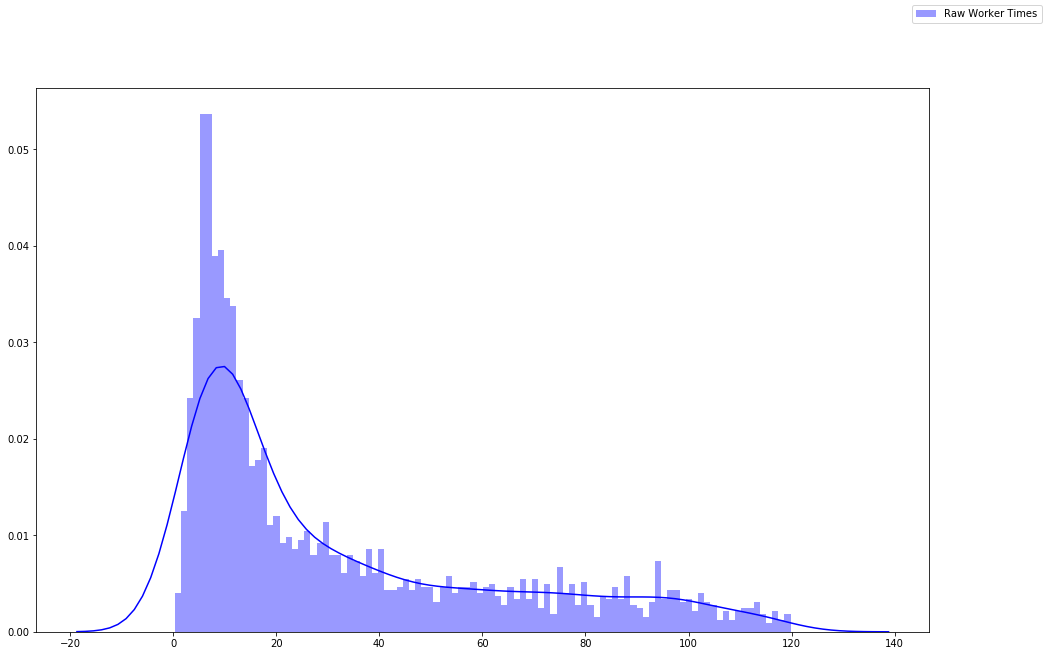

In [25]:
# Distribution of times.
worker_times_raw = [s / 60 for s in worker_times_raw]
print("avg %.2f+/-%.2f (1 std above: %.2f; 2 std above: %.2f)" % 
      (np.average(worker_times_raw), np.std(worker_times_raw),
       np.average(worker_times_raw) + np.std(worker_times_raw),
       np.average(worker_times_raw) + 2*np.std(worker_times_raw)))
fig, ax = plt.subplots(figsize=(16, 10))
sns.distplot(np.array(worker_times_raw),
             color="blue", label="Raw Worker Times", bins=100)
fig.legend()
plt.show()

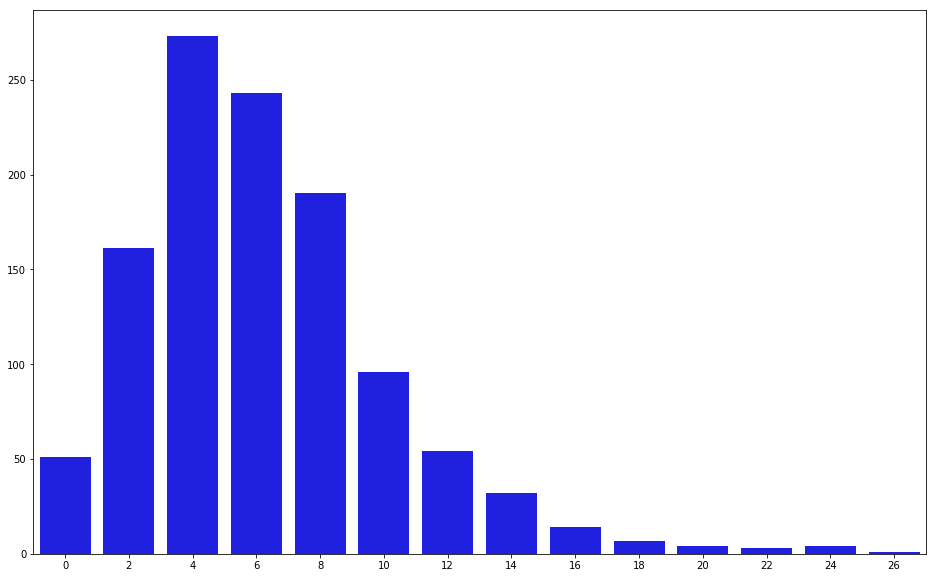

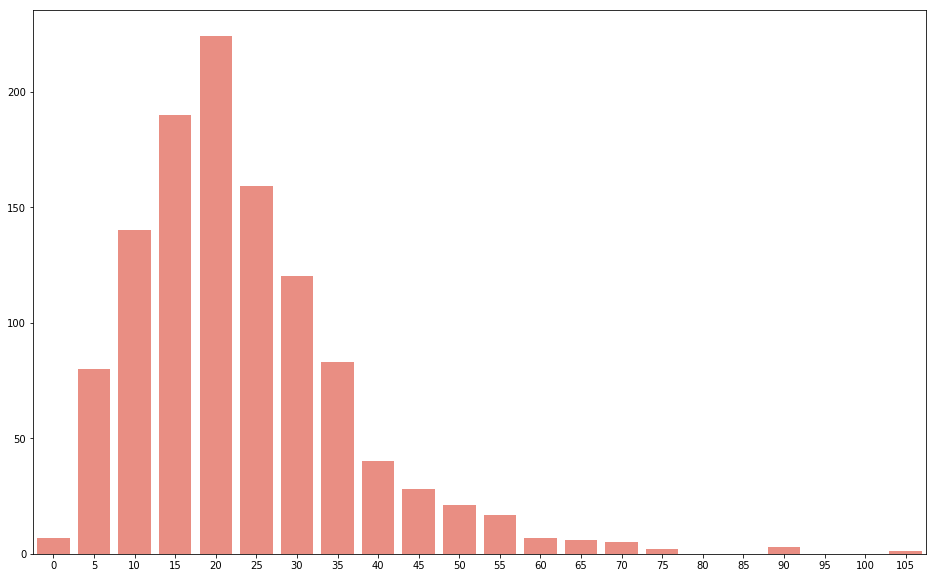

In [4]:
# Distribution of trajectory and dialog lengths.

# Dialog lens.
dialog_bin_size = 2
freq_of_dialog_count_bins = {}
for idx in games.index:
    c = len(games['dialog_history'][idx])
    cbin = c // dialog_bin_size
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
    freq_of_dialog_count_bins[cbin] += 1
for cbin in range(min(freq_of_dialog_count_bins), max(freq_of_dialog_count_bins)):
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
        
# Nav lens.
nav_bin_size = 5
freq_of_nav_count_bins = {}
for idx in games.index:
    c = len(games['nav_steps'][idx])
    cbin = c // nav_bin_size
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0
    freq_of_nav_count_bins[cbin] += 1
for cbin in range(min(freq_of_nav_count_bins), max(freq_of_nav_count_bins)):
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0

fig1, ax1 = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax1,
                 x=[k * dialog_bin_size for k in freq_of_dialog_count_bins],
                 y=[freq_of_dialog_count_bins[k] for k in freq_of_dialog_count_bins],
                 color="blue")
fig2, ax2 = plt.subplots(figsize=(16, 10))
g2 = sns.barplot(ax=ax2,
                 x=[k * nav_bin_size for k in freq_of_nav_count_bins],
                 y=[freq_of_nav_count_bins[k] for k in freq_of_nav_count_bins],
                 color="salmon")
plt.show()

In [5]:
analyze_target = 0  # 0 - word tokens, 1 - pos tags from spacy

def add_to_count_dict(tks, d):
    for tk_pos in tks:
        target = tk_pos[analyze_target]
        if target not in d:
            d[target] = 0
        d[target] += 1

import spacy
nlp = spacy.load("en_core_web_sm")

# Process language into structures.
all_wc = {}
nav_wc = {}
ora_wc = {}
len_at_nav_turn = [[] for _ in range(500)]  # These just have to be high enough; trimmed post-hoc.
len_at_dialog_turn = [[] for _ in range(100)]
total_turns = 0
for idx in games.index:
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        total_turns += 1
        tks = [(tk.text.lower().strip(), tk.pos_) for tk in nlp(turn['message'])]
        tks = [(tk_s, tk_pos) for (tk_s, tk_pos) in tks if len(tk_s) > 0]
        add_to_count_dict(tks, all_wc)
        if turn['role'] == 'navigator':
            add_to_count_dict(tks, nav_wc)
        else:
            add_to_count_dict(tks, ora_wc)
        len_at_nav_turn[turn['nav_idx']].append(len(tks))
        len_at_dialog_turn[tidx].append(len(tks))
len_at_nav_turn = [len_at_nav_turn[idx] for idx in range(len(len_at_nav_turn))
                   if np.any([len(len_at_nav_turn[jdx]) > 0 for jdx in range(idx, len(len_at_nav_turn))])]
len_at_dialog_turn = [len_at_dialog_turn[idx] for idx in range(len(len_at_dialog_turn))
                   if np.any([len(len_at_dialog_turn[jdx]) > 0 for jdx in range(idx, len(len_at_dialog_turn))])]
unique_words = len(all_wc)
total_words = sum([all_wc[w] for w in all_wc])
print("Unique tokens %d; average %.2f words per turn (%d turns); %.2f per game (%d games)" % 
      (unique_words, unique_words / total_turns, total_turns, unique_words / len(games), len(games)))
print("Total words %d; average %.2f words per turn (%d turns); %.2f per game (%d games)" % 
      (total_words, total_words / total_turns, total_turns, total_words / len(games), len(games)))

Unique tokens 2138; average 0.30 words per turn (7066 turns); 1.89 per game (1133 games)
Total words 96668; average 13.68 words per turn (7066 turns); 85.32 per game (1133 games)


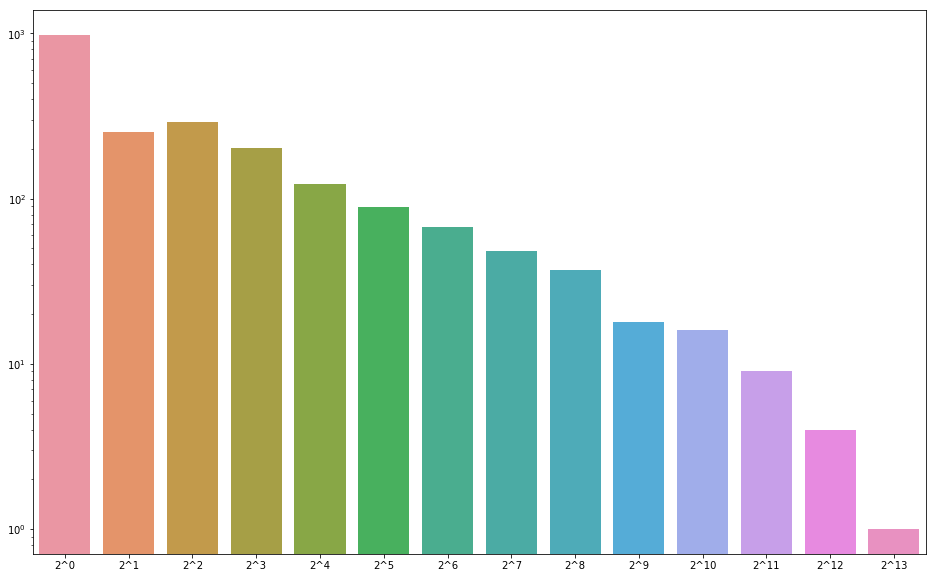

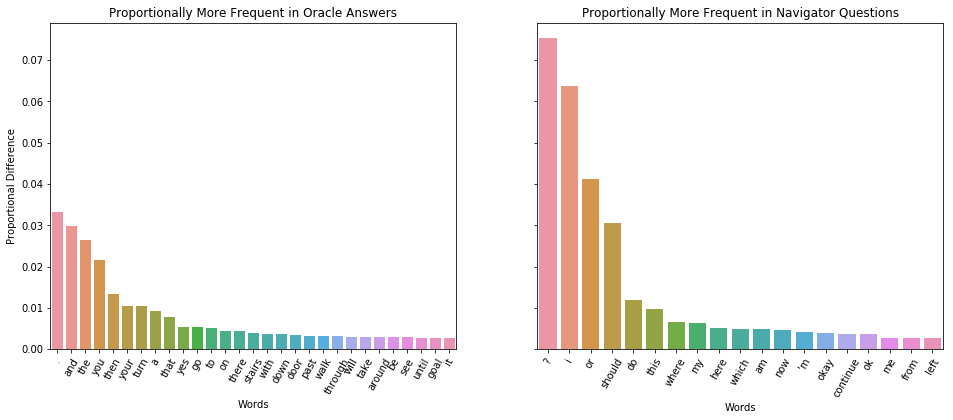

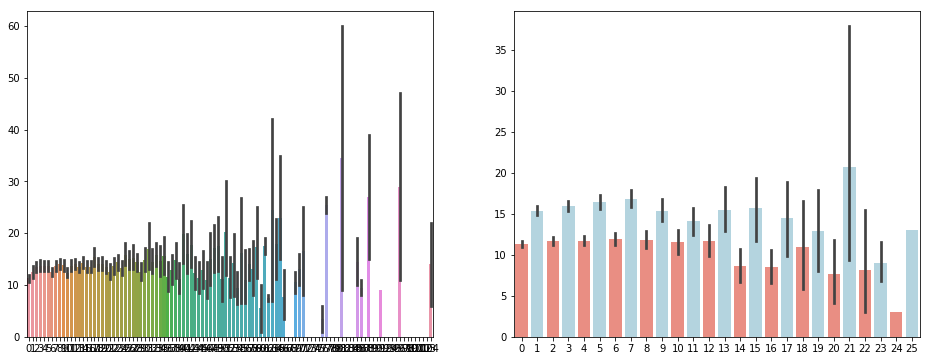

In [6]:
# Distribution of 1 grams
all_cw = flip_dict(all_wc)

freq_count_bins = {}
for w in all_wc:
    c = all_wc[w]
    cbin = int(np.log2(c) + 0.5)
    if cbin not in freq_count_bins:
        freq_count_bins[cbin] = 0
    freq_count_bins[cbin] += 1
        
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(ax=ax,
                x=["2^%d" % k for k in freq_count_bins],
                y=[freq_count_bins[k] for k in freq_count_bins])
ax.set(yscale="log")
plt.show()

# Differences between navigator and oracle utterances
all_voc = set(all_wc.keys())
nav_wc_sum = sum([nav_wc[token] for token in nav_wc])
norm_nav_wc = {token: nav_wc[token] / nav_wc_sum if token in nav_wc else 0 for token in all_voc}
ora_wc_sum = sum([ora_wc[token] for token in ora_wc])
norm_ora_wc = {token: ora_wc[token] / ora_wc_sum if token in ora_wc else 0 for token in all_voc}
sum_ora_diffs = {token: norm_nav_wc[token] - norm_ora_wc[token] for token in all_voc}
tk_diffs = sorted(sum_ora_diffs.items(), key=lambda kv: kv[1])

threshold = 0.0025
rotation = 60
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(16, 6))
ax1.title.set_text('Proportionally More Frequent in Oracle Answers')
ax1.set(xlabel='Words', ylabel='Proportional Difference')
g1 = sns.barplot(x=[pair[0] for pair in tk_diffs if pair[1] < -threshold],
            y=np.array([-pair[1] for pair in tk_diffs  if pair[1] < -threshold]), ax=ax1)
g1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)
ax2.title.set_text("Proportionally More Frequent in Navigator Questions")
ax2.set(xlabel='Words')
g2 = sns.barplot(x=[pair[0] for pair in reversed(tk_diffs) if pair[1] > threshold],
            y=np.array([pair[1] for pair in reversed(tk_diffs) if pair[1] > threshold]), ax=ax2)
g2.set_xticklabels(ax2.get_xticklabels(), rotation=rotation)
plt.show()

# Utterance length against navigation step and dialog turn.
# TODO: two nav bars per step, one for navigator, one for oracle
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(16, 6))
g1 = sns.barplot(data=len_at_nav_turn, ax=ax1)
g2 = sns.barplot(data=len_at_dialog_turn, ax=ax2,
                palette=['salmon' if idx % 2 == 0 else 'lightblue' for idx in range(len(len_at_dialog_turn))])
plt.show()

In [7]:
# Note train/val unseen/test scans and ratios.
r2r_data_dir = '../../../tasks/R2R/data/'
r2r_data_folds = ["train", "val_seen", "val_unseen", "test"]
scans_by_fold = {}
trajs_by_fold = {}
for data_fold in r2r_data_folds:
    scans_by_fold[data_fold] = set()
    trajs_by_fold[data_fold] = 0
    with open(os.path.join(r2r_data_dir, "R2R_%s.json" % data_fold), 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        scans_by_fold[data_fold].add(trajectory['scan'])
        trajs_by_fold[data_fold] += 1
prop_val_seen = trajs_by_fold['val_seen'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])
prop_train = trajs_by_fold['train'] / (trajs_by_fold['val_seen'] + trajs_by_fold['train'])

# Split games into train/val seen/val unseen/test.
np.random.seed(37)  # fix the seed so train/val_seen splits are identical given same data
assigned_train = None  # indices assigned to train
folds_to_games = {}
for fold in r2r_data_folds:
    gidxs = [idx for idx in games.index if games['scan'][idx] in scans_by_fold[fold]]
    if fold == "train":
        indices = list(range(len(gidxs)))
        np.random.shuffle(indices)
        train_n = min(int(np.round(prop_train * len(gidxs))), len(indices) - 1)
        assigned_train = set([gidxs[idx] for idx in indices[:train_n]])
        gidxs = assigned_train
    elif fold == "val_seen":
        indices = list(range(len(gidxs)))
        gidxs = [gidx for gidx in gidxs if gidx not in assigned_train]
    folds_to_games[fold] = gidxs

print("fold, num games")
for fold in r2r_data_folds:
    print("%s, %s" % (fold, len(folds_to_games[fold])))

fold, num games
train, 712
val_seen, 46
val_unseen, 148
test, 221


In [8]:
# Carve out the Instruction Following task.
ins_follow = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                   "scan",  # setting - the house the task takes place in.
                                   "target",  # setting - the target object for the task.
                                   "start_pano",  # setting - the starting pano and camera angles for navigation.
                                   "dialog_history",  # input - dialog history so far.
                                   "nav_history",  # input - navigation pano steps so far.
                                   "nav_camera",  # input - camera movements at last pano up to question.
                                   "planner_path",  # output - the planner sequence steps shown to the oracle.
                                   "player_path",  # output - the steps the navigator actually took.
                                   "R2R_success",  # meta - whether this traj was a success by R2R standards.
                                   "R2R_oracle_success",  # meta - whether traj passed close enough to "target".
                                   "R2R_spl",  # meta - trajectory R2R spl score.
                                   "R2R_oracle_spl",  # meta - trajectory oracle (passed) spl score.
                                   "navigator_game_quality",  # meta - the quality score the oracle gave navigator.
                                   "oracle_game_quality",  # meta - the quality score the navigator gave oracle.
                                   "navigator_worker_quality",  # meta - scores for navigator across games.
                                   "oracle_worker_quality",  # meta - scores for oracle across games.
                                   # TODO: add quality scores to ins_follow and other tasks.
                                  ])
q_asking = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                 "scan",  # setting - the house the task takes place in.
                                 "target",  # setting - the target object for the task.
                                 "start_pano",  # setting - the starting pano and camera angles for navigation.
                                 "dialog_history",  # input - dialog history so far.
                                 "nav_history",  # input - navigation pano steps so far.
                                 "nav_camera",  # input - camera movements at last pano up to question.
                                 "nav_question",  # output - the question the navigator asked at this step.
                                ])
q_answering = pd.DataFrame(columns=["game_idx",  # meta - the game dialog from which this was extracted.
                                    "scan",  # setting - the house the task takes place in.
                                    "target",  # setting - the target object for the task.
                                    "start_pano",  # setting - the starting pano and camera angles for navigation.
                                    "dialog_history",  # input - dialog history so far.
                                    "nav_history",  # input - navigation pano steps so far.
                                    "nav_camera",  # input - camera movements at last pano up to question.
                                    "planner_path",  # input - the planner sequence steps shown to the oracle.
                                    "oracle_answer",  # output - the answer the oracle gave
                                ])

for idx in games.index:
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        if turn['role'] == 'oracle':  # Create a new instance of the instruction following task.
            
            # dialog history is everything before this answer + this answer.
            dialog_history = games['dialog_history'][idx][:tidx + 1]
            dialog_history = [{c: entry[c] for c in ['message', 'role', 'nav_idx']} for entry in dialog_history]

            # nav steps are all steps taken before this q and the one from which this q was answered.
            nav_steps = games['nav_steps'][idx][:turn['nav_idx'] + 1]
            
            # nav camera movements are those associated with this answers nav question.
            nav_camera = None
            for nav_camera_entry in games['nav_camera'][idx]:
                if nav_camera_entry['dia_idx'] == tidx - 1:  # e.g., -1 from oracle answer to nav question.
                    nav_camera = nav_camera_entry['message']
                    
            # the last message from the camera movements is our starting pano+angles
            start_pano = nav_camera[-1]
            # calculate the planner steps shown to the oracle from here to min(goal, +5) ahead.
            shortest_traj = get_shortest_planner_path(games['scan'][idx],
                                                      start_pano['pano'],
                                                      games['end_panos'][idx])
            planner_steps = shortest_traj[:min(5, len(shortest_traj))]
            
            # record the player steps taken until the next question was asked / goal was reached.
            if tidx + 1 < len(games['dialog_history'][idx]):
                next_nav_idx = games['dialog_history'][idx][tidx + 1]['nav_idx']
            else:
                next_nav_idx = len(games['nav_steps'][idx]) - 1
            # Navigator did not move before asking another question.
            if next_nav_idx == turn['nav_idx']:
                continue
            player_steps = list(games['nav_steps'][idx])[turn['nav_idx']:next_nav_idx + 1]
            
            ins_follow = ins_follow.append({"game_idx": idx,
                                            "scan": games['scan'][idx],
                                            "target": games['target'][idx],
                                            "start_pano": start_pano,
                                            "dialog_history": dialog_history,
                                            "nav_history": nav_steps,
                                            "nav_camera": nav_camera,
                                            "planner_path": planner_steps,
                                            "player_path": player_steps,
                                            "R2R_success": int(calculate_success(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_oracle_success": int(calculate_oracle_success(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_spl": float(calculate_spl(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                            "R2R_oracle_spl": float(calculate_oracle_spl(
                                                games['scan'][idx],
                                                player_steps,
                                                planner_steps,
                                                within_meters=METERS_FOR_SUCCESS)),
                                           }, ignore_index=True)
            q_asking = q_asking.append({"game_idx": idx,
                                        "scan": games['scan'][idx],
                                        "target": games['target'][idx],
                                        "start_pano": start_pano,
                                        # strip nav q & oracle ans.
                                        "dialog_history": dialog_history[:-2],
                                        "nav_history": nav_steps,
                                        "nav_camera": nav_camera,
                                        # target is the nav q asked here.
                                        "nav_question": dialog_history[-2]['message'],
                                       }, ignore_index=True)
            q_answering = q_answering.append({"game_idx": idx,
                                              "scan": games['scan'][idx],
                                              "target": games['target'][idx],
                                              "start_pano": start_pano,
                                              # strip oracle ans from input.
                                              "dialog_history": dialog_history[:-1],
                                              "nav_history": nav_steps,
                                              "nav_camera": nav_camera,
                                              "planner_path": planner_steps,
                                              # target is oracle answer.
                                              "oracle_answer": dialog_history[-1]['message'],
                                           }, ignore_index=True)

# Write task data to human-readable JSON files.
for fold in r2r_data_folds:
    d = [{c: ins_follow[c][idx] for c in ins_follow.keys()}
         for idx in ins_follow.index
         if ins_follow["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(instruction_following_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))
        
    d = [{c: q_asking[c][idx] for c in q_asking.keys()}
         for idx in q_asking.index
         if q_asking["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_asking_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

    d = [{c: q_answering[c][idx] for c in q_answering.keys()}
         for idx in q_answering.index
         if q_answering["game_idx"][idx] in folds_to_games[fold]]
    fn = os.path.join(question_answering_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))
    
    d = [{c: games[c][idx] for c in games.keys()}
         for idx in games.index
         if idx in folds_to_games[fold]]
    fn = os.path.join(dialog_navigation_dir, "%s.json" % fold)
    with open(fn, 'w') as f:
        for game in d:
            for k in game:
                if type(game[k]) == np.int64:
                    game[k] = int(game[k])
                elif type(game[k]) == np.float64:
                    game[k] = float(game[k])
        json.dump(d, f, indent=2)
    print("Wrote %d instances to '%s'" % (len(d), fn))

Wrote 2089 instances to '../tasks/instruction_following/train.json'
Wrote 2089 instances to '../tasks/question_asking/train.json'
Wrote 2089 instances to '../tasks/question_answering/train.json'
Wrote 712 instances to '../tasks/dialog_navigation/train.json'
Wrote 129 instances to '../tasks/instruction_following/val_seen.json'
Wrote 129 instances to '../tasks/question_asking/val_seen.json'
Wrote 129 instances to '../tasks/question_answering/val_seen.json'
Wrote 46 instances to '../tasks/dialog_navigation/val_seen.json'
Wrote 388 instances to '../tasks/instruction_following/val_unseen.json'
Wrote 388 instances to '../tasks/question_asking/val_unseen.json'
Wrote 388 instances to '../tasks/question_answering/val_unseen.json'
Wrote 148 instances to '../tasks/dialog_navigation/val_unseen.json'
Wrote 634 instances to '../tasks/instruction_following/test.json'
Wrote 634 instances to '../tasks/question_asking/test.json'
Wrote 634 instances to '../tasks/question_answering/test.json'
Wrote 221 in

In [9]:
# Inspect open feedback.
for wid, feedback in feedbacks:
    if len(feedback.strip()) > 0:
        print("%s: %s" % (wid, feedback.strip()))

A1AKL5YH9NLD2V: It's hard to know what type of questions to ask when I don't know what the interface of the other person is. I didn't know if they could see what I was looking at or not.
AO33H4GL9KZX9: this feels like it takes too long especially when i'm waiting for the partner to reply.
A2YE7NBCK14VAQ: it was kind of hard to figure out whether they needed to go up the stairs or not but nothing too confusing
A1YCGICA8XCNBH: sad they never even said anything.
A1H1TKK54YG94Q: It took probably the first question to sort of "get it" from my perspective as I think my initial instructions weren't great, but got much better.
A3PTO0DMF57GDG: thank you partner
A38LEVBZ3P5F6T: We managed to reach our goal without any difficulty. Thanks for the interesting HIT!
A3CPQP08A6J09F: My partner was great, very responsive and asked great questions and followed directions well.
A3LE1BIVORW3VR: Thank you so much! I hope you can enable the arrow keys on the keyboard to move across the given scenarios
A13WY

In [10]:
# Inspect dialogs.
problem_level = 0
games_viewed = 0
for idx in games.index:
    if games['problem'][idx] < problem_level:
        continue
    games_viewed += 1
    print("idx %d:\nhouse %s, target %s, dialog len %d, nav len %d" %
          (games['idx'][idx], games['scan'][idx], games['target'][idx], len(games['dialog_history'][idx]),
           len(games['nav_steps'][idx])))
    print("problem reported: %d, navigator quality: %d, oracle quality: %d" % 
          (games['problem'][idx], games['navigator_quality'][idx], games['oracle_quality'][idx]))
    for tidx in range(len(games['dialog_history'][idx])):
        turn = games['dialog_history'][idx][tidx]
        print("\t[%d] %s(%s):\t%s" % (turn['nav_idx'], turn['role'], turn['uid'], turn['message']))
    print()
print("viewing %d/%d (%.2f) games" % 
      (games_viewed, len(games), games_viewed / len(games)))

idx 0:
house 82sE5b5pLXE, target trashcan, dialog len 6, nav len 26
problem reported: 0, navigator quality: 4, oracle quality: 4
	[11] navigator(5d01b554b2aa7):	Should I go up the stairs or toward the toilet?
	[11] oracle(5d01b4e132804):	yes i believe so
	[11] navigator(5d01b554b2aa7):	Can you be more specific. Up the stairs or move toward the toilet?
	[11] oracle(5d01b4e132804):	don't go up the stairs look to your right and it's not in the bathroom find a couch
	[22] navigator(5d01b554b2aa7):	Is that the couch I am looking for?
	[22] oracle(5d01b4e132804):	it is blue in color has many pillows on it

idx 1:
house RPmz2sHmrrY, target trashcan, dialog len 6, nav len 14
problem reported: 0, navigator quality: 5, oracle quality: 5
	[0] navigator(5d01b8d157b38):	where do I go?
	[0] oracle(5d01b89ecba6c):	I need you to head to a hallway.
	[5] navigator(5d01b8d157b38):	I am in the hall way
	[5] oracle(5d01b89ecba6c):	Great!  Head to the end of the hall.  When you get to the door with the snow

problem reported: 0, navigator quality: 4, oracle quality: 5
	[12] navigator(5d06d69628ab3):	I can't find an exit from this library. Should I turn left or right?
	[12] oracle(5d06d6d8130d6):	Turn right and start walking around the library.
	[32] navigator(5d06d69628ab3):	Should I continue forward along the table?
	[32] oracle(5d06d6d8130d6):	I see no further steps. I think you're in the correct place.

idx 101:
house V2XKFyX4ASd, target stool, dialog len 4, nav len 27
problem reported: 0, navigator quality: 5, oracle quality: 5
	[7] navigator(5d06edb4e94ac):	Should I leave the den or stay here?
	[7] oracle(5d06edaf28ac0):	turn left go to the backside of the room and up the stairs?
	[19] navigator(5d06edb4e94ac):	Should I go towards the fireplace?
	[19] oracle(5d06edaf28ac0):	go up the stairs again to your right

idx 102:
house rPc6DW4iMge, target nightstand, dialog len 10, nav len 23
problem reported: 0, navigator quality: 5, oracle quality: 2
	[7] navigator(5d06e11f82ed5):	Should I co

	[25] navigator(5d0a9257ac4e6):	Did I go too far?
	[25] oracle(5d0a8eae20f1a):	I didn't see a vase back there so I suggest you continue going forward
	[26] navigator(5d0a9257ac4e6):	Should I go through the doorway ahead?
	[26] oracle(5d0a8eae20f1a):	Yes, continue going forward
	[45] navigator(5d0a9257ac4e6):	Should I go forward or turn around and go back again?
	[45] oracle(5d0a8eae20f1a):	Go forward but continue to scan for the vase
	[57] navigator(5d0a9257ac4e6):	I'm never going to find it. Should I look around the massage room further?
	[57] oracle(5d0a8eae20f1a):	Continue forward.  We need to backtrack a little bit
	[58] navigator(5d0a9257ac4e6):	Do you know if it is a table vase or on the floor?
	[58] oracle(5d0a8eae20f1a):	Go forward to the main lobby
	[62] navigator(5d0a9257ac4e6):	Should I turn right in the lobby?
	[62] oracle(5d0a8eae20f1a):	turn right through the wooden doors ahead
	[77] navigator(5d0a9257ac4e6):	I think I tried that room already. Should I continue forward, o

	[18] oracle(5d0a8db448049):	hallway ahead and room on the right

idx 359:
house e9zR4mvMWw7, target wardrobe, dialog len 6, nav len 18
problem reported: 0, navigator quality: 5, oracle quality: 5
	[7] navigator(5d0aa5d0dd85c):	Should I take a left around the corner?
	[7] oracle(5d0aa5d819c60):	Yep, past the couch, take a left, and then a right next to the white table that's in that room.
	[10] navigator(5d0aa5d0dd85c):	Is this the right way? should I go left or right?
	[10] oracle(5d0aa5d819c60):	We're on the right track! :) Take a right and then a couple of steps forward. There should be some stairs to your right then, and we want to head up those.
	[16] navigator(5d0aa5d0dd85c):	Alright I got a lot of different ways I could mosey on. Left, straight, or right?
	[16] oracle(5d0aa5d819c60):	We're right next to our goal room! Take a right into the room with the blue bedspread. That should be it.

idx 360:
house D7G3Y4RVNrH, target lamp, dialog len 8, nav len 28
problem reported: 0, navi

	[20] oracle(5d0bc5f870424):	Take a right into another bedroom.

idx 450:
house mJXqzFtmKg4, target papertowel, dialog len 10, nav len 55
problem reported: 0, navigator quality: 2, oracle quality: 5
	[3] navigator(5d0bca2d76adc):	where should I move from here? I can't seem to find an entrance.
	[3] oracle(5d0bcac8822d7):	keep going straight.
	[29] navigator(5d0bca2d76adc):	Okay, I'm inside
	[29] oracle(5d0bcac8822d7):	you should try and find a closed door.
	[33] navigator(5d0bca2d76adc):	There is a closed door with a light switch and bathroom next to it
	[33] oracle(5d0bcac8822d7):	walk towards the living room, but make a right before you get there
	[49] navigator(5d0bca2d76adc):	there is a bedroom to my left and a laundry room to the right
	[49] oracle(5d0bcac8822d7):	I would go where one would take their dirty clothes to get cleaned.
	[50] navigator(5d0bca2d76adc):	Found it. The paper towels are on the counter behind the washer.
	[50] oracle(5d0bcac8822d7):	enter.

idx 451:
house V2X

problem reported: 0, navigator quality: 2, oracle quality: 5
	[4] navigator(5d0bd9f195d19):	straight or turn around?
	[4] oracle(5d0bd9f61242e):	Take one step forward, towards that door please

idx 683:
house rPc6DW4iMge, target dresser, dialog len 6, nav len 24
problem reported: 0, navigator quality: 5, oracle quality: 5
	[9] navigator(5d0bd72723df9):	Do I head up the stairs on my left or continue into one of these rooms
	[9] oracle(5d0bd71a5420d):	head up the stairs and down the hallway at the top
	[15] navigator(5d0bd72723df9):	Do I go into the rooms on my left or right?
	[15] oracle(5d0bd71a5420d):	head to your right
	[18] navigator(5d0bd72723df9):	Okay do I need to go deeper or back into the hall and another room?
	[18] oracle(5d0bd71a5420d):	I sent you a little too far. Head back into the hallway. It's astraight shot from the doorway of this room into the goal room. You will pass a painting of a kneeling girl on your right

idx 684:
house VLzqgDo317F, target stool, dialog len 8, 

	[5] navigator(5d0be297c8959):	Turn left or right at the tub?
	[5] oracle(5d0be2a896aac):	from here, go through the door at your 1 oclock, go up the stairs to the right
	[15] navigator(5d0be297c8959):	Do I turn into a room or go straight?
	[15] oracle(5d0be2a896aac):	turn 90 deg right, through the door in the corner by the mirror, first bedroom, into the bathroom

idx 776:
house UwV83HsGsw3, target nightstand, dialog len 10, nav len 38
problem reported: 0, navigator quality: 3, oracle quality: 5
	[1] navigator(5d0bd64431b4c):	Where should I go from here ?
	[1] oracle(5d0bd64b845a6):	forward into the bedroom and try there (it won't show me further)
	[7] navigator(5d0bd64431b4c):	Okay, where from there ?
	[7] oracle(5d0bd64b845a6):	cross the bedroom and go down the hall (it won't show me further)
	[12] navigator(5d0bd64431b4c):	I think I'm lost. Help please ?
	[12] oracle(5d0bd64b845a6):	go back into the bedroom and through the door that will be to your left as you step onto the carpet.


	[9] navigator(5d0bd3488147d):	where to now friend?
	[9] oracle(5d0bd33d8aa3b):	Go into the bedroom and turn to the left through the double doors and into the living room area on the right
	[14] navigator(5d0bd3488147d):	okay!
	[14] oracle(5d0bd33d8aa3b):	go through the kitchen and through the arched doorway straight ahead.  take a left than a quick right towards the dining room
	[21] navigator(5d0bd3488147d):	okay, here!
	[21] oracle(5d0bd33d8aa3b):	Head towards the front door and go into the room on the right with the grand piano
	[25] navigator(5d0bd3488147d):	is thi  it?
	[25] oracle(5d0bd33d8aa3b):	Yes!

idx 797:
house Vt2qJdWjCF2, target sofa, dialog len 0, nav len 18
problem reported: 0, navigator quality: 5, oracle quality: 5

idx 798:
house D7G3Y4RVNrH, target lamp, dialog len 0, nav len 23
problem reported: 0, navigator quality: 5, oracle quality: 5

idx 799:
house VFuaQ6m2Qom, target trashcan, dialog len 4, nav len 14
problem reported: 0, navigator quality: 5, oracle quality

idx 1006:
house r47D5H71a5s, target trashcan, dialog len 4, nav len 14
problem reported: 0, navigator quality: -1, oracle quality: 5
	[6] navigator(5d0be51cee009):	where to?
	[6] oracle(5d0be51bae1cd):	Go straight, past the stairs, and through the open doorway.
	[10] navigator(5d0be51cee009):	yep
	[10] oracle(5d0be51bae1cd):	Go through the doorway that's on a diagonal.

idx 1007:
house ur6pFq6Qu1A, target watercooler, dialog len 14, nav len 34
problem reported: 0, navigator quality: 4, oracle quality: 4
	[6] navigator(5d0bc977e1efe):	should I go straight or left?
	[6] oracle(5d0bc98557729):	Keep on going straight till the very end, and you will find watercooler on your right side.
	[14] navigator(5d0bc977e1efe):	should I go back one step? I don't see a nav point actually in the room
	[14] oracle(5d0bc98557729):	Sorry I got confused with Water Dispenser, Please turn right and keep on going, enter the room and still keep on your right.
	[20] navigator(5d0bc977e1efe):	should i continue fo

	[11] oracle(5d0bd95f40882):	Walk to your left past the round table and go up the curving staircase
	[20] navigator(5d0bd95dec452):	Upon reaching the top of the staircase, should I go left or should I go right?
	[20] oracle(5d0bd95f40882):	Start to your left but then take an immediate right down a narrow hallway into a bedroom
	[24] navigator(5d0bd95dec452):	I should not enter the bathroom and continue straight into the bedroom?
	[24] oracle(5d0bd95f40882):	Enter the bedroom ahead

idx 1161:
house YVUC4YcDtcY, target screen, dialog len 6, nav len 16
problem reported: 0, navigator quality: 5, oracle quality: 2
	[3] navigator(5d0bebf9eb0ce):	Do I follow the blue line to the right or head towards the yellow line on the left?
	[3] oracle(5d0bebec1fe71):	go left
	[8] navigator(5d0bebf9eb0ce):	Straight into the conference room or left down the hallway?
	[8] oracle(5d0bebec1fe71):	turn directly around and go to double doors
	[15] navigator(5d0bebf9eb0ce):	These doors here correct?
	[15] oracl

In [11]:
# See players' success rates, ratings, and existing qualifications.
import csv
qual_fn = "resources/worker_quals.csv"  # The workers CSV downloaded from Mturk on the "Manage Workers" tab.
qual_csv = pd.read_csv(qual_fn)
players = {}
game_missing_known_worker = 0
for idx in games.index:
    for role in ['navigator', 'oracle']:
        if games[role][idx] not in uids_to_workers:
            print("WARNING: uid '%s' missing from known workers but has finished, added game %d" % 
                  (games[role][idx], idx))
            game_missing_known_worker += 1
            continue
        wid = uids_to_workers[games[role][idx]]
        if games['%s_quality' % role][idx] == -1:
            print("WARNING: wid '%s' never received a rating in game %d" % (wid, idx))
            continue
        if wid not in players:
            row_v = qual_csv.loc[qual_csv['Worker ID'] == wid, 'CURRENT-MP-Dialog']
            if not np.isnan(row_v.values[0]):
                existing_qual = row_v.values[0]
            else:
                existing_qual = 0
            players[wid] = {"qual": existing_qual, "uids": [], "pids": [], "game_idxs": [], "ratings": []}
        players[wid]["uids"].append(games[role][idx])
        players[wid]["pids"].append(games['navigator' if role == 'oracle' else 'oracle'][idx])
        players[wid]["game_idxs"].append(games['idx'][idx])
        players[wid]["ratings"].append(games['%s_quality' % role][idx])
# Players to qual at 3 no matter what because of bad behavior.
blacklist = {'A31681CCEVDIH3'}
# Players we trust based on email communication, etc, to override timeout qual.
timeout_whitelist = {'AKVQTFH16ICGZ', 'A2BLQ1GVEHJR8T', 'A2Q3FS9G8ITCN7', 'A1GVTH5YS3WOK0', 'APKZZ03P89DHY'}
qual_level = 4
timeout_limit = 1
selfplay_limit = 1
game_limit = 40
qualed_count = 0
reliable_by_game = 3
qualed_and_reliable_count = 0
for wid in players:
    existing_qual = players[wid]['qual']
    avg_r = np.average(players[wid]['ratings'])
    rounded_qual = int(avg_r + 0.5)
    update_str = ''
    updated_qual = None
    
    if wid in blacklist:
        updated_qual = 3
        update_str = "BLACKLIST fixed qual %d" % updated_qual
    
    if updated_qual is None:
        if wid in workers_to_timeouts:
            if wid in timeout_whitelist:
                print("WARNING: whitelisting %s who has %d submitted timeouts" % (wid, workers_to_timeouts[wid]))
            elif workers_to_timeouts[wid] >= timeout_limit:
                updated_qual = min(3, int(rounded_qual))
                if updated_qual <= rounded_qual:
                    update_str = "TIMEOUT! FLOORING TO %d" % updated_qual
                    
    if updated_qual is None:
        if wid in workers_to_selfplay and workers_to_selfplay[wid] >= selfplay_limit:
            updated_qual = min(3, int(rounded_qual))
            if updated_qual <= rounded_qual:
                update_str = "SELF-PLAY! FLOORING TO %d" % updated_qual
                    
    if updated_qual is None:
        if len(players[wid]['game_idxs']) >= game_limit:
            updated_qual = 6
            if updated_qual > existing_qual:
                update_str = "MAXED OUT! Setting qual to %d" % updated_qual
    
    if updated_qual is None:
        if rounded_qual != existing_qual:
            updated_qual = int(rounded_qual)
            update_str = "UPDATING TO %d" % updated_qual
    
    if updated_qual is not None:
        qual_csv.at[qual_csv['Worker ID'] == wid, 'UPDATE-MP-Dialog'] = updated_qual
        if updated_qual >= qual_level:
            qualed_count += 1
            if len(players[wid]['ratings']) >= reliable_by_game:
                qualed_and_reliable_count += 1
    else:
        if existing_qual >= qual_level:
            qualed_count += 1
            if len(players[wid]['ratings']) >= reliable_by_game:
                qualed_and_reliable_count += 1
    
    print("%s avg rating %.2f [qual=%d] %s" % (wid, avg_r, existing_qual, update_str))
    print("\t" + ", ".join(["%d(g=%d)" % (players[wid]['ratings'][idx], players[wid]['game_idxs'][idx])
                            for idx in range(len(players[wid]['game_idxs']))]))
    if wid in workers_to_timeouts:
        print("\t%d submitted timeouts" % workers_to_timeouts[wid])
    if wid in workers_to_selfplay:
        print("\t%d submitted self-play" % workers_to_selfplay[wid])
print("%d/%d workers have qual>=%d" % (qualed_count, len(players), qual_level))
print("%d/%d workers have qual>=%d with #games>=%d" %
      (qualed_and_reliable_count, len(players), qual_level, reliable_by_game))
with open(qual_fn + ".update.csv", 'w') as f:
    f.write(qual_csv.to_csv(index=False, quoting=csv.QUOTE_ALL, float_format="%.0f"))
print("%d/%d games missing an indexed worker" % (game_missing_known_worker, len(games)))

A2DVV59R1CQU6T avg rating 4.65 [qual=5] 
	5(g=193), 5(g=397), 5(g=436), 5(g=517), 5(g=556), 5(g=570), 5(g=680), 3(g=699), 5(g=704), 5(g=784), 2(g=806), 5(g=870), 4(g=881), 5(g=921), 5(g=971), 5(g=973), 5(g=1009), 5(g=1020), 5(g=1067), 4(g=1156)
A1UAYZY1GUN3I2 avg rating 5.00 [qual=5] 
	5(g=453)
AGC3T6724JUAF avg rating 5.00 [qual=5] 
	5(g=452)
A1P0XSCJ9XAV74 avg rating 4.08 [qual=4] 
	3(g=482), 4(g=676), 3(g=692), 5(g=693), 1(g=700), 4(g=715), 5(g=793), 5(g=798), 5(g=913), 5(g=1046), 4(g=1062), 5(g=1066)
A20FCMWP43CVIU avg rating 5.00 [qual=5] 
	5(g=181)
A2E3TO92MCQ9XU avg rating 4.81 [qual=5] 
	5(g=164), 5(g=312), 4(g=447), 5(g=509), 5(g=529), 5(g=537), 5(g=628), 4(g=654), 5(g=660), 5(g=701), 5(g=706), 5(g=740), 5(g=809), 5(g=882), 4(g=1007), 5(g=1069)
A2RVFMCKSSEHDV avg rating 4.00 [qual=4] 
	4(g=487)
A39YBLQYIUBR76 avg rating 3.00 [qual=3] 
	3(g=444)
AU2NVT51E749C avg rating 5.00 [qual=5] 
	5(g=484)
A35CL66BEUSJ5Z avg rating 3.53 [qual=4] 
	4(g=11), 5(g=472), 4(g=516), 2(g=601), 5(g